In [598]:
import string
import numpy
import requests
import urllib.request
import json
from pprint import pprint
from bs4 import BeautifulSoup
import re
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from collections import Counter
import nltk
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

In [554]:
with open("All Songs.txt", "r", encoding = 'utf-8') as f:
    songs = f.readlines()
songs = [x.strip() for x in songs]
print("done")

done


In [555]:
with open("Artists Mapped to Songs.txt", "r", encoding = 'utf-8') as f:
    artists = f.readlines()
artists = [x.strip() for x in artists]
print("done")

done


In [556]:
def clean_words(wordlist):
    stop = set(stopwords.words('english'))
    stop = stop.union(set(('the', 'one', 'i')))
    wordlist = wordlist.split()
    wordlist = [s.lower() for s in wordlist]
    wordlist = [s for s in wordlist if s not in stop]
    wordlist = [''.join(c for c in s if c not in string.punctuation) for s in wordlist]
    wordlist = [s + " " for s in wordlist if s]    
    return ''.join(wordlist)

In [557]:
def stem(wordlist): #Use Dict stemmer
    newlist = []
    lemmatizer = nltk.stem.WordNetLemmatizer()
    wordlist = wordlist.split()
    for word in wordlist:
        newlist.append(lemmatizer.lemmatize(word) + " ")
    return ''.join(newlist)    

In [558]:
count = 0
for i in range(len(songs)):
    count += 1
    songs[i] = clean_words(songs[i])
    songs[i] = stem(songs[i])
    if(count%1000 == 0):

        print(count)

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000


# Starting Combining Stuff

In [580]:
PERCENTAGE_TRAIN = 0.90
PERCENTAGE_TEST = 1 - PERCENTAGE_TRAIN
CLASSIFIER_SIZE = 2048
MAX_FEATURES = 10000

In [560]:
def runCombination():
    # zip and shuffle
    combined = [ (a,b) for a, b in zip(artists, songs)]
    random.shuffle(combined)

    # get counts per artist
    artist_counts = {}
    for pair in combined:
        if pair[0] in artist_counts:
            artist_counts[pair[0]]["total songs"] = artist_counts[pair[0]]["total songs"] + 1
        elif len(artist_counts) < CLASSIFIER_SIZE:
            artist_counts[pair[0]] = {"total songs" : 1}

    # set number of training songs per artist
    for artist in artist_counts:
        total_songs = artist_counts[artist]["total songs"]
        artist_counts[artist]["training size"] = int(PERCENTAGE_TRAIN * total_songs)

    # songs and artists
    combined_artists_json = {}

    for pair in combined:
        song = pair[1]
        artist = pair[0]
        if artist in artist_counts:
            training_size = artist_counts[artist]["training size"]

            if artist not in combined_artists_json:
                combined_artists_json[artist] = { "test" : [], "train" : ""}

            if training_size > 0:
                combined_artists_json[artist]["train"] = combined_artists_json[artist]["train"] + song + " "
                training_size -= 1
                artist_counts[artist]["training size"] = training_size
            else:
                combined_artists_json[artist]["test"].append(song)

    # add to train and test set 
    test_artists = []
    test_songs = []
    train_artists = []
    train_songs = []
    for artist in combined_artists_json:
        train_artists.append(artist)
        train_songs.append(combined_artists_json[artist]["train"])
        for test_song in combined_artists_json[artist]["test"]:
            test_artists.append(artist)
            test_songs.append(test_song)
    return test_artists, test_songs, train_artists, train_songs

In [561]:
def idf():
    text_clf_idf = Pipeline([('vect', CountVectorizer(input=train_songs, lowercase=True, max_df=1.0, max_features=MAX_FEATURES)),\
                     ('tfidf', TfidfTransformer()), ('clf', MultinomialNB()),])
    text_clf_idf = text_clf_idf.fit(train_songs, train_artists)
    return numpy.mean(text_clf_idf.predict(test_songs) == test_artists)

In [562]:
def tf():
    text_clf_tf = Pipeline([('vect', CountVectorizer(input=train_songs, lowercase=True, max_df=1.0, max_features=MAX_FEATURES)),\
                     ('tfidf', TfidfTransformer(use_idf=False)), ('clf', MultinomialNB()),])
    text_clf_tf = text_clf_tf.fit(train_songs, train_artists)
    return numpy.mean(text_clf_tf.predict(test_songs) == test_artists)

In [563]:
def svm():
    text_clf_svm = Pipeline([('vect', CountVectorizer(input=train_songs, lowercase=True, max_df=1.0, max_features=MAX_FEATURES)),\
                     ('tfidf', TfidfTransformer()), \
                    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, n_iter=5, random_state=42))])
    text_clf_svm = text_clf_svm.fit(train_songs, train_artists)
    return numpy.mean(text_clf_svm.predict(test_songs) == test_artists)

In [565]:
train_artists[:5]

['Blondie', 'Stevie Nicks', 'Procol Harum', 'The Black Keys', 'Sting']

In [596]:
y_idf = []
y_tf = []
y_svm = []

In [597]:
classifier_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1082]
for classifier_size in classifier_sizes:
    values = []
    CLASSIFIER_SIZE = classifier_size
    for i in range(10):
        test_artists, test_songs, train_artists, train_songs = runCombination()
        mae_idf = idf()
        mae_tf = tf()
        mae_svm = svm()
        values.append([mae_idf, mae_tf, mae_svm])
    mae_idf, mae_tf, mae_svm = numpy.average(values, axis=0)
    y_idf.append(mae_idf)
    y_tf.append(mae_tf)
    y_svm.append(mae_svm)
    print("class size", CLASSIFIER_SIZE, "idf %2f" % mae_idf, "tf %2f" %  mae_tf, "svm %2f" %  mae_svm)

class size 2 idf 0.883919 tf 0.890513 svm 0.872808
class size 4 idf 0.792720 tf 0.775782 svm 0.769361
class size 8 idf 0.561089 tf 0.521534 svm 0.530515
class size 16 idf 0.450650 tf 0.367683 svm 0.367105
class size 32 idf 0.390753 tf 0.311995 svm 0.314018
class size 64 idf 0.319726 tf 0.256386 svm 0.262223
class size 128 idf 0.243657 tf 0.180229 svm 0.190580
class size 256 idf 0.184587 tf 0.135271 svm 0.132661
class size 512 idf 0.139835 tf 0.104650 svm 0.091997
class size 1082 idf 0.102869 tf 0.076423 svm 0.064021


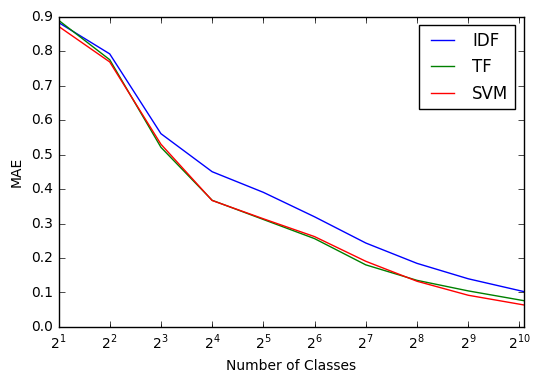

In [613]:
plt.xlabel('Number of Classes') 
plt.ylabel('MAE')
line1, = plt.plot(classifier_sizes, (y_idf), label="IDF", linewidth=1)
line2, = plt.plot(classifier_sizes, (y_tf), label="TF", linewidth=1)
line3, = plt.plot(classifier_sizes, (y_svm), label="SVM", linewidth=1)
plt.xscale('log', basex=2)
plt.xlim([0, 1082])
plt.legend(handles=[line1, line2, line3], loc=1)
plt.show()